In [23]:
import numpy as np, matplotlib.pyplot as plt, random, time
from functools import lru_cache
from pyquil import Program, get_qc
from pyquil.gates import *
import os
from pyquil.quilatom import quil_sin, quil_cos, Parameter
from pyquil.quilbase import DefGate
from pyquil.latex import display, to_latex
# import Peres_helpers as hf
import pickle
from collections import Counter

Z_SCORE = 3
N_SHOTS = 10_000

# Helpers
def dura(func):
	'''
	A wrapper function to calculate the time of any process we want.
	'''
	def wrapper(*args, **kwargs):
		start = time.time()
		print(f'{func.__name__} has started.')
		val = func(*args, **kwargs)
		ty_res = time.gmtime(time.time() - start)
		res = time.strftime("%H:%M:%S",ty_res)
		print(f'{func.__name__} completed in {res}')
		return val
	return wrapper

def params_real():
	'''
	Generates parameters to prepare random REAL quantum states.
	'''
	theta = np.arccos(np.cos(e) - 2 * np.array([random.uniform(0,1) for _ in range(3)]))
	phi = np.array([(np.pi)*random.randint(0,1) for _ in range(3)])
	params = zip(theta, phi)
	return list(params)
def params_complex():
	'''
	Generates parameters to prepare COMPLEX quantum states.
	'''
	theta = np.arccos(np.cos(e) - 2 * np.array([random.uniform(0,1) for _ in range(3)]))
	phi = np.array([2*np.pi*random.uniform(0,1) for _ in range(3)])
	params = zip(theta, phi)
	return list(params)

n_shots = 10_000
e = 0

# Sigma calculation. This function executes the circuit.
def sigma(params, params_ancilla):
	'''
	Compile and run the circuit given the parameters. The list of outputs is returned.
	'''
	params = list(zip(*params)) # Unpack parameters
	theta, phi = params[0], params[1] # Store thetas and phis in seperate tuples.
	
	bitstrings = qc.run(exe, memory_map={'theta': theta, 'phi': phi, 'th':[params_ancilla]}) # Stores the output of the circuit run.
	return bitstrings

# Gammas for different pairs of states.
def g(u):
    '''
    Calls the sigma function with different values of parameters correponding to the configurations, |ψ12>, |ψ1> and |ψ2>. Returns a
    dictionary with configurations as keys and output as values (which are lists).
    '''
    params = list(zip(*u)) # Unpack parameters
    theta, phi = params[0], params[1] # Store thetas and phis in seperate tuples.
    s12 = qc.run(exe, memory_map={'theta': theta, 'phi': phi, 'theta_m':[np.pi/2]}) # Stores the output of the circuit run.
    s12 = Counter([''.join(list(map(str, elem))) for elem in s12])
    
    #### NEW LINES
    s1 = qc.run(exe, memory_map={'theta': theta, 'phi': phi, 'theta_m':[0]}) # Stores the output of the circuit run.
    s1 = Counter([''.join(list(map(str, elem))) for elem in s1])
    
    s2 = qc.run(exe, memory_map={'theta': theta, 'phi': phi, 'theta_m':[np.pi]}) # Stores the output of the circuit run.
    s2 = Counter([''.join(list(map(str, elem))) for elem in s2])
    
    #### NEW LINES END

#     s1 = qc.run(exe1, memory_map={'theta': theta, 'phi': phi}) # Stores the output of the circuit run.
#     s1 = Counter([''.join(list(map(str, elem))) for elem in s1])

#     return s12#{'s12': s12, 's1': s1}
    return {'s12': s12['00'], 's1': s1['00'], 's2': s2['00']}

# Computing all the three gammas.
@dura # To calculate the time taken for all the circuits to run.
def f(u):
	'''
	Calls the g function to run the circuit for different configurations and returns a dictionary with 'a', 'b', 'c' as keys and the corresponding 
	outputs of the three configurations. This marks the end of what the Quantum computer must be used for. After this it is all about post-
	processing the data.
	'''
	alpha = g([u[0], u[1]]) # Running for alpha
	beta = g([u[1], u[2]]) # Running for beta
	gamma = g([u[2], u[0]]) # Running for gamma

	res = {'a': alpha, 'b': beta, 'c': gamma}

	return res


def circuit1(qubit1, qubit2):
    circ = Program()
    
    c = circ.declare('ro', 'BIT', 2)
    theta = circ.declare('theta', 'REAL', 2)
    phi = circ.declare('phi', 'REAL', 2)
    
    # Preparation of states.
    circ += RY(theta[0], qubit1)
    circ += RZ(phi[0], qubit1)
    
    circ += RY(theta[1], qubit2)
    circ += RZ(-phi[1], qubit2)
    
#     circ += X(qubit1)
    
    # Measuring in psi+ basis
    circ += CNOT(qubit1, qubit2)
    circ += H(qubit1)
    
    circ += MEASURE(qubit1, c[0])
    circ += MEASURE(qubit2, c[1])
    
    circ.wrap_in_numshots_loop(n_shots)
    
    return circ

def circuit2(qubit1, qubit2):
    circ = Program()
    
    c = circ.declare('ro', 'BIT', 2)
    theta = circ.declare('theta', 'REAL', 2)
    phi = circ.declare('phi', 'REAL', 2)
    
    # Preparation of states.
    circ += RY(theta[0], qubit1)
    circ += RZ(phi[0], qubit1)
    
    circ += RY(theta[1], qubit2)
    circ += RZ(-phi[1], qubit2)
    
    circ += X(qubit1)
    circ += MEASURE(qubit1, c[0])
    circ += MEASURE(qubit2, c[1])
    circ.wrap_in_numshots_loop(n_shots)
    
    return circ



In [54]:
data = {}
data['State_params'] = params_complex()

In [57]:
all_F = []
all_a = []
all_b = []
all_c = []
q1, q2 = 4, 5
trial=2
folder = f'new_peres_{datetime.date.today()}_{q1}_{q2}_bits_{N_SHOTS}_shots_trial_{trial}'
os.system(f'mkdir {folder}')

for i in range(10):
    qc = get_qc('Aspen-9')#, as_qvm=True) # Initialise QPU.

    circ1 = circuit1(q1,q2)
    exe12 = qc.compile(circ1)
    
    data = {}
    data['State_params'] = params_complex()

    data['Counts12'] = f(data['State_params'])

    qc = get_qc('Aspen-9')#, as_qvm=True) # Initialise QPU.

    circ1 = circuit2(q1,q2)
    exe12 = qc.compile(circ1)

    data['Counts1'] = f(data['State_params'])
    
    with open(f'{folder}/run_{i}', 'wb') as file:
        pickle.dump(data, file)
    

    def get_gammas(counts12, counts1):
        res = {}
        for gamma in counts12.keys():
            g = (2*counts12[gamma]['00'] - counts1[gamma]['10'] - counts1[gamma]['01']) / (2 * np.sqrt(counts1[gamma]['10']*counts1[gamma]['01']))
            res[gamma] = g

        res['F'] = res['a']**2 + res['b']**2 + res['c']**2 - 2 * res['a'] * res['b'] * res['c']
        return res

    all_gammas = get_gammas(data['Counts12'], data['Counts1'])
    all_a.append(all_gammas['a'])
    all_b.append(all_gammas['b'])
    all_c.append(all_gammas['c'])
    all_F.append(all_gammas['F'])
    print(f'Done with iteration {i}', end='\r')

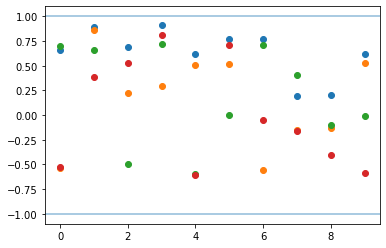

In [59]:
plt.plot(all_F, 'o')
plt.plot(all_a, 'o')
plt.plot(all_b, 'o')
plt.plot(all_c, 'o')
plt.axhline(y=1, alpha=0.5)
plt.axhline(y=-1, alpha=0.5)

In [60]:
plt.savefig('new_peres_trial_2.pdf', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

In [37]:
data

{'State_params': [(1.6119578092283906, 3.8604713997244513),
  (2.0237554491141503, 2.1574590388656065),
  (1.415889513124443, 0.5106591612010841)],
 'Counts12': {'a': Counter({'01': 4622, '00': 2265, '10': 2808, '11': 305}),
  'b': Counter({'01': 671, '11': 4640, '10': 2578, '00': 2111}),
  'c': Counter({'10': 4775, '01': 1752, '11': 3409, '00': 64})},
 'Counts1': {'a': Counter({'01': 3708, '10': 1340, '00': 1460, '11': 3492}),
  'b': Counter({'00': 4198, '01': 2966, '11': 1194, '10': 1642}),
  'c': Counter({'11': 2961, '01': 2239, '10': 2742, '00': 2058})}}

In [6]:
def theoretical_values(data):
    data['Theoretical_values'] = {}
    data['Theoretical_values']['a'] = np.cos(data['State_params'][1][1] - data['State_params'][0][1])
    data['Theoretical_values']['b'] = np.cos(data['State_params'][2][1] - data['State_params'][1][1])
    data['Theoretical_values']['c'] = np.cos(data['State_params'][0][1] - data['State_params'][2][1])
    
    data['Theoretical_values']['F']=data['Theoretical_values']['a']**2 + data['Theoretical_values']['b']**2 + data['Theoretical_values']['c']**2 - 2 * data['Theoretical_values']['a']*data['Theoretical_values']['b']*data['Theoretical_values']['c']
    
    return data

In [38]:
data = theoretical_values(data)
data

{'State_params': [(1.6119578092283906, 3.8604713997244513),
  (2.0237554491141503, 2.1574590388656065),
  (1.415889513124443, 0.5106591612010841)],
 'Counts12': {'a': Counter({'01': 4622, '00': 2265, '10': 2808, '11': 305}),
  'b': Counter({'01': 671, '11': 4640, '10': 2578, '00': 2111}),
  'c': Counter({'10': 4775, '01': 1752, '11': 3409, '00': 64})},
 'Counts1': {'a': Counter({'01': 3708, '10': 1340, '00': 1460, '11': 3492}),
  'b': Counter({'00': 4198, '01': 2966, '11': 1194, '10': 1642}),
  'c': Counter({'11': 2961, '01': 2239, '10': 2742, '00': 2058})},
 'Theoretical_values': {'a': -0.1318311574502368,
  'b': -0.07593039907897672,
  'c': -0.9784005095556622,
  'F': 1.0}}

In [12]:
def expected_probs(data):
    data['Expected_probs'] = {}
    gammas = ['a', 'b', 'c']
    for i in range(3):
        data['Expected_probs'][gammas[i]] = {}
        theta1 = data['State_params'][i][0]
        theta2 = data['State_params'][(i+1)%3][0]
        phi1 = data['State_params'][i][1]
        phi2 = data['State_params'][(i+1)%3][1]
        data['Expected_probs'][gammas[i]]['P_12'] = np.cos(theta1/2)**2 * np.cos(theta2/2)**2 + np.sin(theta1/2)**2 * np.sin(theta2/2)**2 + 2 * np.abs(np.cos(theta1/2) * np.cos(theta2/2) * np.sin(theta1/2) * np.sin(theta2/2)) * np.cos(phi2 - phi1)
        
        data['Expected_probs'][gammas[i]]['P_1'] = np.cos(theta1/2)**2 * np.cos(theta2/2)**2 
        data['Expected_probs'][gammas[i]]['P_2'] = np.sin(theta1/2)**2 * np.sin(theta2/2)**2 
        
    return data

In [39]:
data = expected_probs(data)
data

{'State_params': [(1.6119578092283906, 3.8604713997244513),
  (2.0237554491141503, 2.1574590388656065),
  (1.415889513124443, 0.5106591612010841)],
 'Counts12': {'a': Counter({'01': 4622, '00': 2265, '10': 2808, '11': 305}),
  'b': Counter({'01': 671, '11': 4640, '10': 2578, '00': 2111}),
  'c': Counter({'10': 4775, '01': 1752, '11': 3409, '00': 64})},
 'Counts1': {'a': Counter({'01': 3708, '10': 1340, '00': 1460, '11': 3492}),
  'b': Counter({'00': 4198, '01': 2966, '11': 1194, '10': 1642}),
  'c': Counter({'11': 2961, '01': 2239, '10': 2742, '00': 2058})},
 'Theoretical_values': {'a': -0.1318311574502368,
  'b': -0.07593039907897672,
  'c': -0.9784005095556622,
  'F': 1.0},
 'Expected_probs': {'a': {'P_12': 0.4497859788629208,
   'P_1': 0.13480757957930772,
   'P_2': 0.3741965892284113},
  'b': {'P_12': 0.43251172326344944,
   'P_1': 0.16228477104921707,
   'P_2': 0.3039548358101331},
  'c': {'P_12': 0.013892404392512103,
   'P_1': 0.27669730956695265,
   'P_2': 0.22012822500226067}}

In [16]:
def del_probs(p):
    return Z_SCORE * np.sqrt(p * (1-p) / N_SHOTS)

In [19]:
def expected_del_probs(data):
    exp_probs = data['Expected_probs']
    
    data['Fluctuation'] = {}
    
    for key in exp_probs.keys():
        data['Fluctuation'][key] = {}
        for key2 in exp_probs[key].keys():
            data['Fluctuation'][key][key2] = del_probs(exp_probs[key][key2])
    
    return data
            

In [40]:
data = expected_del_probs(data)
data

{'State_params': [(1.6119578092283906, 3.8604713997244513),
  (2.0237554491141503, 2.1574590388656065),
  (1.415889513124443, 0.5106591612010841)],
 'Counts12': {'a': Counter({'01': 4622, '00': 2265, '10': 2808, '11': 305}),
  'b': Counter({'01': 671, '11': 4640, '10': 2578, '00': 2111}),
  'c': Counter({'10': 4775, '01': 1752, '11': 3409, '00': 64})},
 'Counts1': {'a': Counter({'01': 3708, '10': 1340, '00': 1460, '11': 3492}),
  'b': Counter({'00': 4198, '01': 2966, '11': 1194, '10': 1642}),
  'c': Counter({'11': 2961, '01': 2239, '10': 2742, '00': 2058})},
 'Theoretical_values': {'a': -0.1318311574502368,
  'b': -0.07593039907897672,
  'c': -0.9784005095556622,
  'F': 1.0},
 'Expected_probs': {'a': {'P_12': 0.4497859788629208,
   'P_1': 0.13480757957930772,
   'P_2': 0.3741965892284113},
  'b': {'P_12': 0.43251172326344944,
   'P_1': 0.16228477104921707,
   'P_2': 0.3039548358101331},
  'c': {'P_12': 0.013892404392512103,
   'P_1': 0.27669730956695265,
   'P_2': 0.22012822500226067}}

In [41]:
data

{'State_params': [(1.6119578092283906, 3.8604713997244513),
  (2.0237554491141503, 2.1574590388656065),
  (1.415889513124443, 0.5106591612010841)],
 'Counts12': {'a': Counter({'01': 4622, '00': 2265, '10': 2808, '11': 305}),
  'b': Counter({'01': 671, '11': 4640, '10': 2578, '00': 2111}),
  'c': Counter({'10': 4775, '01': 1752, '11': 3409, '00': 64})},
 'Counts1': {'a': Counter({'01': 3708, '10': 1340, '00': 1460, '11': 3492}),
  'b': Counter({'00': 4198, '01': 2966, '11': 1194, '10': 1642}),
  'c': Counter({'11': 2961, '01': 2239, '10': 2742, '00': 2058})},
 'Theoretical_values': {'a': -0.1318311574502368,
  'b': -0.07593039907897672,
  'c': -0.9784005095556622,
  'F': 1.0},
 'Expected_probs': {'a': {'P_12': 0.4497859788629208,
   'P_1': 0.13480757957930772,
   'P_2': 0.3741965892284113},
  'b': {'P_12': 0.43251172326344944,
   'P_1': 0.16228477104921707,
   'P_2': 0.3039548358101331},
  'c': {'P_12': 0.013892404392512103,
   'P_1': 0.27669730956695265,
   'P_2': 0.22012822500226067}}

In [21]:
import datetime

In [50]:
f'{datetime.date.today()}'

'2021-06-03'

In [24]:
def new_circuit(qubit1, qubit2):
    circ = Program()
    
    c = circ.declare('ro', 'BIT', 2)
    theta = circ.declare('theta', 'REAL', 2)
    phi = circ.declare('phi', 'REAL', 2)
    theta_m = circ.declare('theta_m', 'REAL')
    
    # Preparation of states.
    circ += RY(theta[0], qubit1)
    circ += RZ(phi[0], qubit1)
    
    circ += RY(theta[1], qubit2)
    circ += RZ(-phi[1], qubit2)
    
#     circ += X(qubit1)
    
    # Measuring in psi+ basis
    circ += CNOT(qubit1, qubit2)
    circ += RY(-theta_m, qubit1)
#     circ += H(qubit1)
    
    circ += MEASURE(qubit1, c[0])
    circ += MEASURE(qubit2, c[1])
    
    circ.wrap_in_numshots_loop(n_shots)
    
    return circ

In [29]:
def get_gammas(counts):
    res = {}
    for gamma in counts.keys():
        g = (2*counts[gamma]['s12'] - counts[gamma]['s1'] - counts[gamma]['s2']) / (2 * np.sqrt(counts[gamma]['s1']*counts[gamma]['s2']))
        res[gamma] = g

    res['F'] = res['a']**2 + res['b']**2 + res['c']**2 - 2 * res['a'] * res['b'] * res['c']
    return res
all_F = []
all_a = []
all_b = []
all_c = []
q1, q2 = 12, 13
trial=2
engine = ''
folder = f'new_peres_{engine}_{datetime.date.today()}_{q1}_{q2}_bits_{N_SHOTS}_shots_trial_{trial}'
os.system(f'mkdir {folder}')

for i in range(20):
    qc = get_qc('Aspen-9', as_qvm=True) # Initialise QPU.

    circ = new_circuit(q1,q2)
    exe = qc.compile(circ)
    
    data = {}
    data['State_params'] = params_complex()

    data['Counts'] = f(data['State_params'])
    
    with open(f'{folder}/run_{i}', 'wb') as file:
        pickle.dump(data, file)
    

    

    all_gammas = get_gammas(data['Counts'])

    all_a.append(all_gammas['a'])
    all_b.append(all_gammas['b'])
    all_c.append(all_gammas['c'])
    all_F.append(all_gammas['F'])
    print(f'Done with iteration {i}', end='\r')

f has started.
f completed in 00:00:05
f has started.ation 0
f completed in 00:00:05
f has started.ation 1
f completed in 00:00:05
f has started.ation 2
f completed in 00:00:05
f has started.ation 3
f completed in 00:00:05
f has started.ation 4
f completed in 00:00:05
f has started.ation 5
f completed in 00:00:05
f has started.ation 6
f completed in 00:00:05
f has started.ation 7
f completed in 00:00:05
f has started.ation 8
f completed in 00:00:05
f has started.ation 9
f completed in 00:00:05
f has started.ation 10
f completed in 00:00:05
f has started.ation 11
f completed in 00:00:05
f has started.ation 12
f completed in 00:00:05
f has started.ation 13
f completed in 00:00:05
f has started.ation 14
f completed in 00:00:05
f has started.ation 15
f completed in 00:00:05
f has started.ation 16
f completed in 00:00:05
f has started.ation 17
f completed in 00:00:05
f has started.ation 18
f completed in 00:00:05


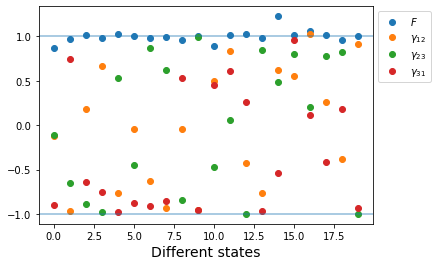

In [34]:
plt.plot(all_F, 'o', label='$F$')
plt.plot(all_a, 'o', label='$\\gamma_{12}$')
plt.plot(all_b, 'o', label='$\\gamma_{23}$')
plt.plot(all_c, 'o', label='$\\gamma_{31}$')
plt.axhline(y=1, alpha=0.5)
plt.axhline(y=-1, alpha=0.5)
plt.xlabel('Different states', size=14)
plt.legend(bbox_to_anchor=(1,1))
plt.savefig('New_peres_sim.pdf', bbox_inches='tight')
plt.show()

In [19]:
all_F

[1.004832546149361,
 1.078952583204265,
 0.9800174232231793,
 0.9477843425297314,
 1.0579536188464698,
 0.8454126259645142,
 1.0097770718662487,
 1.0115757480974028,
 0.9339391423971313,
 0.9475556554992984]

In [14]:
data

{'State_params': [(0.43518429388724245, 4.664009246635776),
  (2.2983011998689755, 0.4317748762856595),
  (2.168886937616118, 5.3692794514615345)],
 'Counts': {'a': {'s12': 1241, 's1': 1296, 's2': 1258},
  'b': {'s12': 3816, 's1': 3717, 's2': 3803},
  'c': {'s12': 1650, 's1': 1632, 's2': 1616}}}

In [16]:
all_gammas

{'a': -0.028194193721730043,
 'b': 0.01489459105503708,
 'c': 0.01601004647217356,
 'F': 0.0012865295397468158}